# Three Body Problem

Three bodies orbit under the influence of gravity.  In general, the motion is chaotic and no practical closed form solution is known.  In practice the problem can be solved using numerical integrators.<br>
See https://en.wikipedia.org/wiki/Three-body_problem for a detailed discussion on the theory and history of this problem.

In [1]:
# Library imports
import tensorflow as tf
import rebound
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import plot_loss_hist, EpochLoss, TimeHistory
from tf_utils import Identity

from orbital_element import OrbitalElementToConfig, ConfigToOrbitalElement, MeanToTrueAnomaly, G_
from orbital_element import make_model_elt_to_cfg, make_model_cfg_to_elt

from g3b_data import make_traj_g3b, make_data_g3b, make_datasets_g3b
from g3b_data import make_datasets_solar, make_datasets_hard
from g3b_plot import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy, plot_orbit_element
from g3b import KineticEnergy_G3B, PotentialEnergy_G3B, Momentum_G3B, AngularMomentum_G3B
from g3b import VectorError, EnergyError
from g3b import Motion_G3B, make_physics_model_g3b
from g3b import compile_and_fit
# from g3b_model_math import make_position_model_g3b_math, make_model_g3b_math
# from g3b_model_nn import make_position_model_g3b_nn, make_model_g3b_nn

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Lightweight serialization
fname = '../data/g3b/g3b.pickle'
vartbl = load_vartbl(fname)

### Orbital Elements Refresher

![title](../figs/web/orbital-elements.png)

**Variable Names of Six Keplerian Orbital Elements**
* `a` - semi-major axis; size of the ellipse; mean of periapsis and apoapsis distances
* `e` - eccentricity; shape of the ellipse.  e=0 is a circle, e=1 is a line.  $e^2 = 1 - b^2 / a^2$
* `inc` - inclination; angle between orbital and ecliptic planes
* `Omega` - longitude of the asending node; undefined when inc=0
* `omega` - argument of pericenter; true anomaly where body is closest to the primary.
* `f` - true anomaly; angle of the orbiting body in its orbital plane

**Two Additional Elements**
* `M` - mean anomaly; area swept out by the orbiting body, normalized so a full orbit is $2 \pi$.  Because of the rule of equal area in equal time, a.k.a. conservation of angular momentum, the mean anomly is linear in time
* `N` - mean motion; rate at which mean anomly changes, i.e. $2 \pi / T$ where $T$ is the orbital period

### Generate and Visualize One Example Orbital Path

The module `g3b_data.py` includes functions used to generate training data for the (general) three body problem.<br>
The function `make_traj_g3b` generates a single trajectory for the G3B problem.  It takes as inputs the masses of the three bodies, `m`; and the six traditional orbital elements (`a`, `e`, `inc`, `Omega`, `omega`, `f`).  The mass is an array of size 3, and each orbital element is an array of size 2.  Orbital elements describe the relationship between two bodies, or here the relationship between body i and the center of mass of bodies 0 through i-1.<br>
`make_traj_g3b` creates a new Rebound simulation with three particles: the sun and two orbiting bodies.  The sun has mass 1.0 in solar mass units, and initial position and velocity 0.<br>
The first orbiting body orbits around the primary (body 0, similar tot he sun) with initial position and velocity are assigned by Rebound based on the orbital elements.<br>
The second orbiting body orbits around the center of mass of body 0 and body 1.  In practice this will be very close to the primary.  This choice of coordinates is called Jacobi coordinates.<br>
The orbit is evaluated for a period of `n_years` with `sample_freq` observations per year.
Here I used 100 years and 10 observations per year, leading to 1001 data points counting both the start and end point.  The results are returned in two Dict objects named inputs and outputs.<br>
**Inputs**
* t - vector of times at which the orbit was sampled
* q0 - initial position of the bodies; shape (num_particles, space_dims,) = (3, 3,)
* v0 - initial velocity of the bodies; shape (num_particles, space_dims,) = (3, 3,)
* m - mass of the bodies in solar masses; shape (num_particles,) = (3,)

**Outputs**
* q - orbital positions of the bodies over time; shape (N, 3, 3,)
* v - orbital velocitiy of body 1 over time; shape (N, 3, 3,)
* a - orbital acceleration of body 1 over time;  shape (N, 3, 3,)
* q0_rec - recovered initial position of bodies; duplicate of q0_init
* v0_rec - recovered initial velocity of bodies; duplicate of v0_init
* T - the kinetic energy of the system; $T = \frac{1}{2} \sum_{i=1}^{3}{m_i |v_i|^2}$
* U - the potential energy of the system; 
$$U = \sum_{i=1}^{3}\sum_{j=i+1}^{3} \frac{-G m_i m_i}{r_{ij}}$$
where $r_{ij} = |qi - qj|$ is the distance between bodies $i$ and $j$
* H - the total energy in the system $H = T + U$
* P - the momentum, $P = \sum{m_i \cdot v_i}$
* L - the angular momentum, $L = \sum{q_i \times m_i v_i}$

In [5]:
# Generate one example trajectory with orbiting earth-like and jupiter-like planets
# https://ssd.jpl.nasa.gov/txt/p_elem_t1.txt
m = np.array([1.0, 1.0E-6, 1.0E-3])
a = np.array([1.00000, 5.2029])
e = np.array([0.0167, 0.0484])
inc = np.radians([0.00, 1.3044])
Omega = np.radians([0.00, 100.47])
omega = np.radians([102.94, 14.73]) - Omega
f = np.radians([100.46, 34.40]) - Omega
n_years = 100
sample_freq = 10

inputs_traj, outputs_traj = make_traj_g3b(m=m, a=a, e=e, inc=inc, Omega=Omega, omega=omega, f=f, 
                                          n_years=n_years, sample_freq=sample_freq)

# Combined dict
data_traj = {**inputs_traj, **outputs_traj}

# Review the fields
print('Input fields:', list(inputs_traj.keys()))
print('Output fields:', list(outputs_traj.keys()))

Input fields: ['t', 'q0', 'v0', 'm']
Output fields: ['q', 'v', 'a', 'orb_a', 'orb_e', 'orb_inc', 'orb_Omega', 'orb_omega', 'orb_f', 'q0_rec', 'v0_rec', 'T', 'U', 'H', 'P', 'L']


In [6]:
# Plot style 
plot_style()

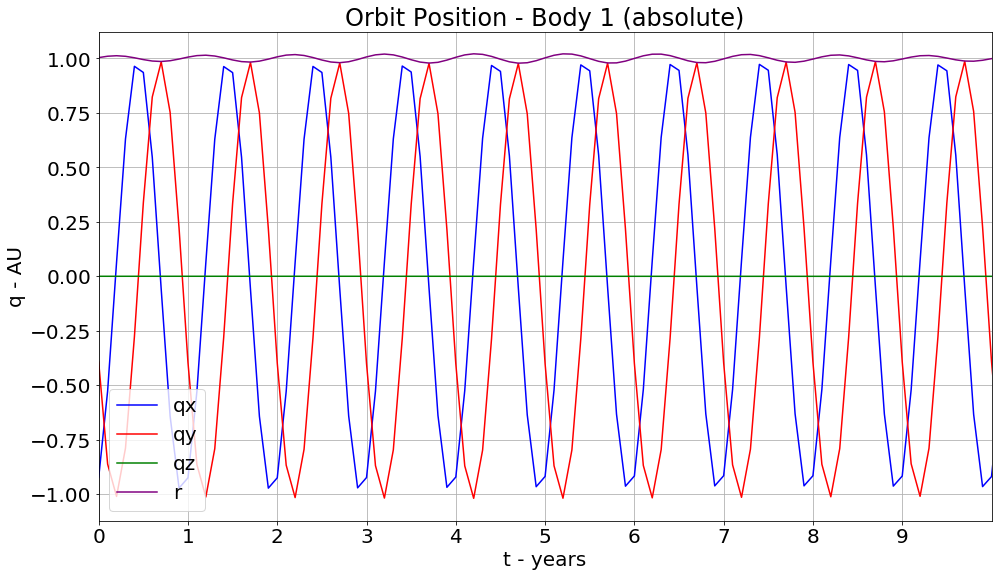

In [7]:
fig, ax = plot_orbit_q(data_traj, 1, False, 10.0)

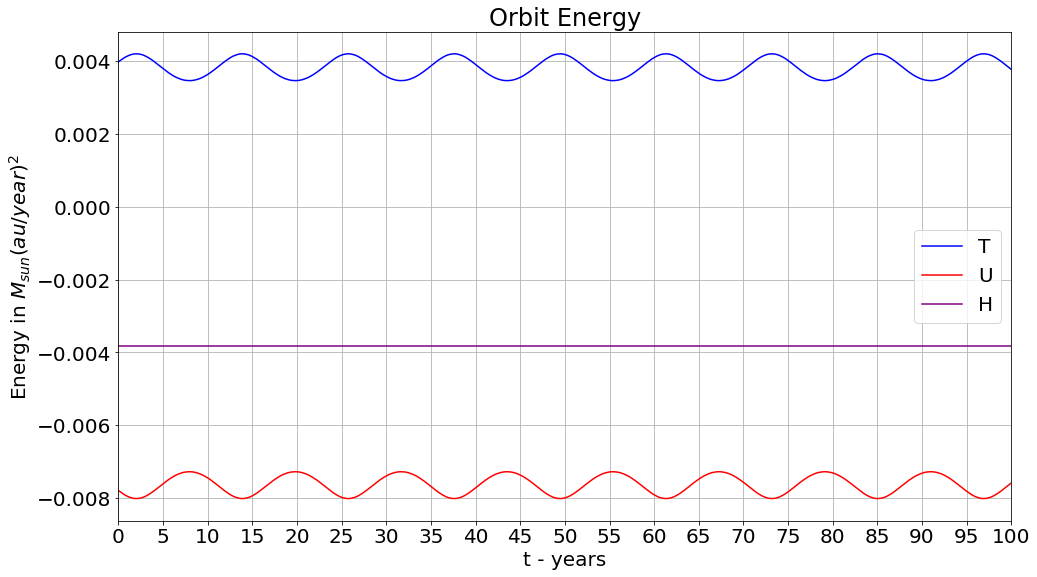

In [8]:
fig, ax = plot_orbit_energy(data_traj)

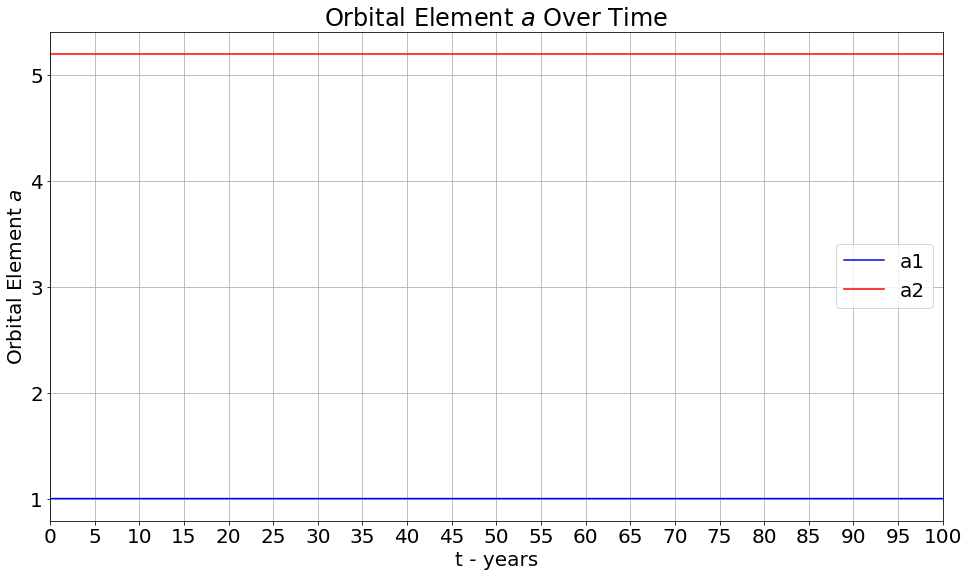

In [9]:
fig, ax = plot_orbit_element(data_traj, 'a')

In [14]:
# fig, ax = plot_orbit_element(data_traj, 'e')

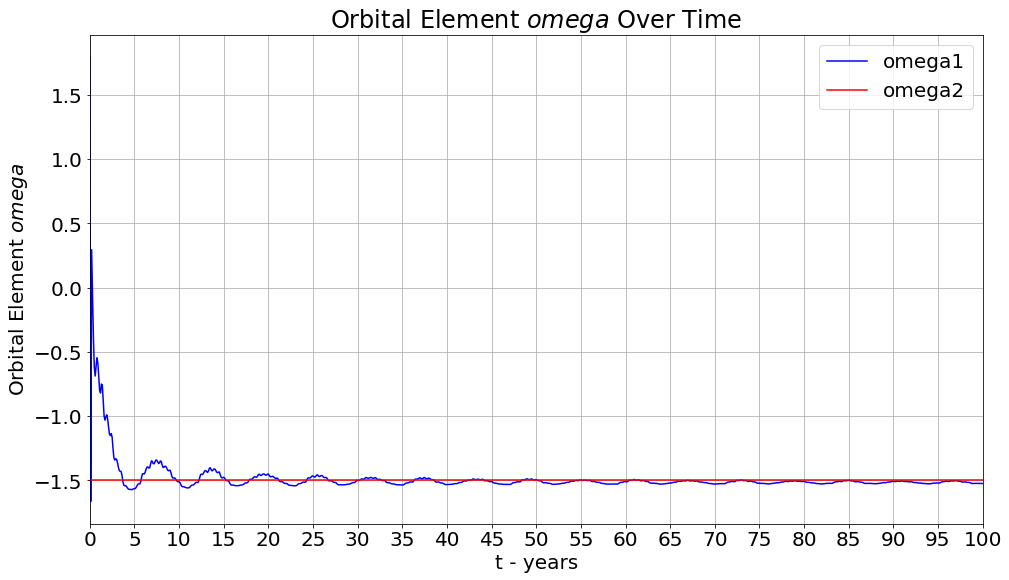

In [11]:
fig, ax = plot_orbit_element(data_traj, 'omega')

In [13]:
# fig, ax = plot_orbit_element(data_traj, 'f')

### Generate Training Data with a Range of Orbital Parameters

The function `make_train_g3b` creates training data for the general 3 body problem in the form of dictionaries of numpy arrays.  These are analogous to the outputs of `make_traj_r3b`, but there is an outer index of `n_traj` different trajectories.  The inputs `m_min` and `m_max` control the mass range of bodies 2 and 3 solar units; the first body always has mass equal to 1 solar unit.<br>
The inputs `a_min`, `a_max`, `e_max`, and `inc_max` determine the sampling ranges for the parameters `a`, `e` and `inc` of the orbital elements of the starting configuration. <br>
The other orbital elements (`Omega`, `omega`, `f`) are sampled over the full range of admissible values.<br>
The function `make_datasets_r3b` generates three tensorflow Dataset objects for train, validation and test, respectively.  Data is generated in the form of Numpy arrays using `make_train_g3b` because it is easier to serialize in that format.  The function checks on disk to see if the data is already available, and if so, loads it.  Otherwise it generates and then saves it.  Effective serialization is critical because the data set is expensive to generate.

In [15]:
# Inputs for make_train_g2b
m_min = 1.0E-7
m_max = 2.0E-3
n_traj = 10
n_years = 100
sample_freq = 10
a_min = 0.50
a_max = 32.0
e_max = 0.08
inc_max = 0.04
seed = 42

In [16]:
# Test make_data_g2b
inputs, outputs= make_data_g3b(n_traj=n_traj, n_years=n_years, sample_freq=sample_freq,
                               a_min=a_min, a_max=a_max, e_max=e_max, inc_max=inc_max, seed=seed)

In [17]:
# Inputs for make_datasets_g3b
n_traj = 100
vt_split = 0.20
n_years = 100
sample_freq = 10

# The batch size
batch_size = 64

In [18]:
# Create DataSet objects for toy size problem - binary type orbits
ds_small_trn, ds_small_val, ds_small_tst = make_datasets_solar(n_traj=n_traj, vt_split=vt_split, 
                                                               n_years=n_years, sample_freq=sample_freq)

Loaded data from ../data/g3b/2509250945.pickle.


In [19]:
# Create a medium data set with 10,000 solar type orbits
n_traj = 10000

ds_small_trn, ds_small_val, ds_small_tst = make_datasets_solar(n_traj=n_traj, vt_split=vt_split, 
                                                               n_years=n_years, sample_freq=sample_freq)

Loaded data from ../data/g3b/398004947.pickle.


***Generating 14,000 trajectories takes about 52 minutes on my server and uses about 2.03 GB of disk space.***<br>
Pace is about 4.5 trajectories per second. Storage requirements about 145 KB / trajectory.

### Review One Example Batch of Training Data

In [20]:
# Example batch
batch_in, batch_out = list(ds_small_trn.take(1))[0]
print('Input field names: ', list(batch_in.keys()))
print('Output field names:', list(batch_out.keys()))

t = batch_in['t']
q0 = batch_in['q0']
v0 = batch_in['v0']
m = batch_in['m']

q = batch_out['q']
v = batch_out['v']
a = batch_out['a']
q0_rec = batch_out['q0_rec']
v0_rec = batch_out['v0_rec']
H = batch_out['H']
P = batch_out['P']
L = batch_out['L']

print(f'\nExample batch sizes:')
print(f't  = {t.shape}')
print(f'q0 = {q0.shape}')
print(f'v0 = {v0.shape}')
print(f'm  = {m.shape}')

print(f'q  = {q.shape}')
print(f'v  = {v.shape}')
print(f'a  = {a.shape}')
# print(f'q0_rec = {q0_rec.shape}')
# print(f'v0_rec = {v0_rec.shape}')
print(f'H  = {H.shape}')
print(f'P  = {P.shape}')
print(f'L  = {L.shape}')

Input field names:  ['t', 'q0', 'v0', 'm']
Output field names: ['q', 'v', 'a', 'q0_rec', 'v0_rec', 'T', 'U', 'H', 'P', 'L']

Example batch sizes:
t  = (64, 1001)
q0 = (64, 3, 3)
v0 = (64, 3, 3)
m  = (64, 3)
q  = (64, 1001, 3, 3)
v  = (64, 1001, 3, 3)
a  = (64, 1001, 3, 3)
H  = (64, 1001)
P  = (64, 1001, 3)
L  = (64, 1001, 3)


### Custom Keras Layers with Physics Computations of Energy and Angular Momentum

The module `g3b.py` contains shared elements used in the general 3 body problem.<br>
The layer `KineticEnergy_G3B` computes the kinetic energy of the system given the object masses `m` with shape (3,) and the velocities `v` with shape (traj_size, 3, 3).<br>
The kinetetic energy is $T = \frac{1}{2} \sum m_i |v_i|^2$ <br>
The layer `PotentialEnergy_G3B` computes the potential energy of the system given the masses `m` and the positions `q` with shape (traj_size, 3, 3).  <br>
The potential energy 
$$U = -\sum_{i<j}{\frac{G m_i m_j}{r_{ij}}}$$ 
where $r_{ij} = |q_j - q_i|$. For the 3 body problem there are ${3}\choose{2} = 3$ interaction pairs.<br>
The layer `Momentum_G3B` computes the momentum of the system given its masses `m`, and velocity `v`. This quantity will be constant by conservation of momentum.  In the center of momentum frame adopted by convention, both the momentum and center of mass will be the zero vector.<br>
The momentum $P = \sum m_i v_i$<br>
The layer `AngularMomentum_G3B` computes the angular momentum of the system given its masses `m`, position `q` and velocity `v`.<br>
The angular momentum $L = \sum q_i \times m_i v_i$, the 3D vector cross product.

In addition to the custom layers computing the physical quantities, there are also custom loss functions intended to be used with them.<br>
The custom loss function `VectorError` returns the relative error 
$$E = \frac{|y_{true} - y_{pred}|}{|y_{true}| + R}$$
where $R$ is an optional regularization term that defaults to 0.<br>
The custom loss function `EnergyError` returns a log scaled squared error
$$E = \log{\left[1 + \left(\frac{y_{pred} - y_{true}}{y_{true}}\right)^2\right]}$$
The log scaling is introduced so that the error doesn't blow up catastrophically when distance gets too small.  This was causing problems in training when an un-scaled energy error was used.

**Call layers with physics computations**

In [21]:
T = KineticEnergy_G3B()([m, v])
T.shape

TensorShape([64, 1001])

In [51]:
class PotentialEnergy_G3B(keras.layers.Layer):
    """Compute the potential energy from masses m and positions q"""
    def __init__(self, **kwargs):
        super(PotentialEnergy_G3B, self).__init__(**kwargs)
        # Compute the norm of a 3D vector
        self.norm_func = lambda q : tf.norm(q, axis=-1, keepdims=False)
    
    def call(self, inputs):
        # Unpack inputs
        # Shape of m is (batch_size, num_particles,)
        # Shape of q is (batch_size, traj_size, num_particles, 3,)
        m, q = inputs

        # The gravitational constant; numerical value close to 4 pi^2; see rebound documentation for exact value        
        G = tf.constant(G_)
        # Gravitational field strength
        m0 = m[:, 0]
        m1 = m[:, 1]
        m2 = m[:, 2]
        k_01 = G * m0 * m1
        k_02 = G * m0 * m2
        k_12 = G * m1 * m2

        # The displacement q_12
        q0 = q[:, :, 0, :]
        q1 = q[:, :, 1, :]
        q2 = q[:, :, 2, :]
        q_01 = q1 - q0
        q_02 = q2 - q0
        q_12 = q2 - q1

        # The distance r; shape (batch_size, num_particles, traj_size)
        r_01 = keras.layers.Activation(self.norm_func, name='r_01')(q_01)
        r_02 = keras.layers.Activation(self.norm_func, name='r_02')(q_02)
        r_12 = keras.layers.Activation(self.norm_func, name='r_12')(q_12)

        # Reshape gravitational field constant to match r
        target_shape = [1] * (len(r_01.shape)-1)
        k_01 = keras.layers.Reshape(target_shape, name='k_01_vec')(k_01)
        k_02 = keras.layers.Reshape(target_shape, name='k_02_vec')(k_02)
        k_12 = keras.layers.Reshape(target_shape, name='k_12_vec')(k_12)
        
        # The gravitational potential is -G mi mj / r_1i = - k_ij / r_ij
        U = tf.negative(tf.reduce_sum([tf.divide(k_01, r_01),
                                       tf.divide(k_02, r_02),
                                       tf.divide(k_12, r_12),],
                                      axis=0, keepdims=False))

        return U

    def get_config(self):
        return dict()

In [52]:
U = PotentialEnergy_G3B()([m, q])
U.shape

TensorShape([64, 1001])

In [53]:
P = Momentum_G3B()([m, v])
P.shape

TensorShape([64, 1001, 3])

In [54]:
L = AngularMomentum_G3B()([m, q, v])
L.shape

TensorShape([64, 1001, 3])